
Last 10 balance stats:
1039: HOLD | Price: $207.49 | Balance: $121941.36
1040: BUY 58.59 shares at $208.14 | Balance: $109747.23
1041: SELL 58.59 shares at $209.07 | Balance: $121995.84
1042: HOLD | Price: $213.25 | Balance: $121995.84
1043: HOLD | Price: $214.10 | Balance: $121995.84
1044: HOLD | Price: $210.62 | Balance: $121995.84
1045: BUY 56.28 shares at $216.75 | Balance: $109796.26
1046: BUY 49.85 shares at $220.27 | Balance: $98816.63
1047: SELL 106.13 shares at $221.55 | Balance: $122329.81
1048: HOLD | Price: $226.34 | Balance: $122329.81

Final Balance: $122329.81


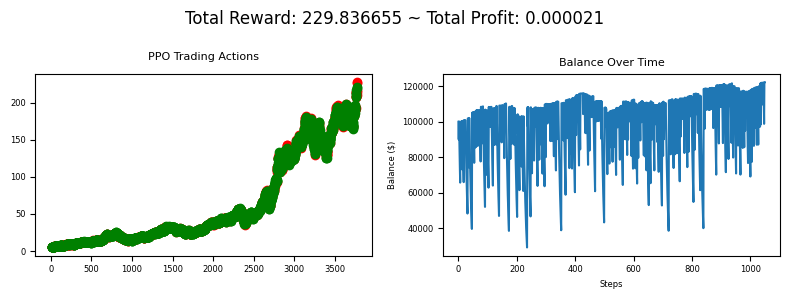

In [22]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import gymnasium as gym, gym_anytrading
from gym_anytrading.envs import Actions
from stable_baselines3 import PPO

data = pd.read_csv("/Users/liuliu/Desktop/PPO Project/Ticker.csv", parse_dates=True, index_col='Date')
env = gym.make('stocks-v0', df=data, window_size=10, frame_bound=(10, len(data)))
balance, shares_held, step = 100000, 0, 0
balance_history, balance_output = [balance], []

# Train model
observation, _ = env.reset(seed=2024)
model = PPO('MlpPolicy', env, verbose=0).learn(total_timesteps=10000)

# Trading loop
while True:
    action, _ = model.predict(observation)
    current_price = env.unwrapped.prices[env.unwrapped._current_tick]
    observation, _, terminated, truncated, _ = env.step(action)
    trade_amount = balance * 0.10
    
    if action == Actions.Buy.value:
        shares_to_buy = trade_amount / current_price
        shares_held += shares_to_buy
        balance -= trade_amount
        balance_output.append(f"{step}: BUY {shares_to_buy:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
    elif action == Actions.Sell.value and shares_held > 0:
        balance += shares_held * current_price
        balance_output.append(f"{step}: SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
        shares_held = 0
    else:
        balance_output.append(f"{step}: HOLD | Price: ${current_price:.2f} | Balance: ${balance:.2f}")
    
    balance_history.append(balance)
    step += 1
    if terminated or truncated: break

if shares_held > 0:
    balance += shares_held * current_price
    balance_output.append(f"\nFinal SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
    
print("\nLast 10 balance stats:", "\n".join(balance_output[-10:]), f"\nFinal Balance: ${balance:.2f}", sep='\n')

plt.figure(figsize=(8, 3)); plt.subplot(121); env.unwrapped.render_all()
plt.title("PPO Trading Actions", fontsize=8, pad=10); plt.tick_params(labelsize=6)
plt.subplot(122); plt.plot(balance_history)
plt.title("Balance Over Time", fontsize=8); plt.xlabel("Steps", fontsize=6); plt.ylabel("Balance ($)", fontsize=6)
plt.tick_params(labelsize=6); plt.tight_layout(); plt.show()